In [25]:
#%pip install pyyaml requests rasterio owslib tqdm xarray

import sys
sys.path.append('..')

from src.data.wapor_downloader import WaPORDownloader
import os
import yaml
from datetime import datetime

In [10]:
# Vérifier que la configuration existe
config_path = '../config/config.yaml'
if os.path.exists(config_path):
    print("✓ Fichier de configuration trouvé")
    with open(config_path, 'r') as f:
        config = yaml.safe_load(f)
        print(f"  Pays: {config['study_area']['country']}")
        print(f"  Années: {config['temporal']['start_year']}-{config['temporal']['end_year']}")
else:
    print("✗ Fichier config.yaml non trouvé!")

✓ Fichier de configuration trouvé
  Pays: Tunisia
  Années: 2015-2023


In [53]:
# Reload the module to get the updated code
import importlib
from src.data import wapor_downloader
importlib.reload(wapor_downloader)
from src.data.wapor_downloader import WaPORDownloader

# Initialize downloader with WaPOR v3 API
downloader = WaPORDownloader(config_path=config_path)

# Test connection
if downloader.connect_api():
    print("\n✓ Prêt à télécharger les données WaPOR v3!")

ℹ️  GDAL non disponible - utilisation de rasterio pour le découpage
✓ WaPOR v3 Downloader initialisé
  API: https://data.apps.fao.org/gismgr/api/v2/catalog/workspaces/WAPOR-3/mapsets
  Période: 2015-2023
  Zone: Tunisia (bbox: [7.5, 30.0, 11.6, 37.5])
✓ WaPOR v3 Downloader initialisé
  API: https://data.apps.fao.org/gismgr/api/v2/catalog/workspaces/WAPOR-3/mapsets
  Période: 2015-2023
  Zone: Tunisia (bbox: [7.5, 30.0, 11.6, 37.5])
✓ Connexion à l'API WaPOR v3 réussie

✓ Prêt à télécharger les données WaPOR v3!
✓ Connexion à l'API WaPOR v3 réussie

✓ Prêt à télécharger les données WaPOR v3!


## Explorer les données WaPOR v3 disponibles

In [51]:
# Lister les mapsets disponibles (optionnel - pour explorer)
mapsets = downloader.list_available_mapsets()


📋 Mapsets WaPOR v3 disponibles:
  - L1-AETI-A: Actual EvapoTranspiration and Interception (Global - Annual - 300m)
  - L1-AETI-D: Actual EvapoTranspiration and Interception (Global - Dekadal - 300m)
  - L1-AETI-M: Actual EvapoTranspiration and Interception (Global - Monthly - 300m)
  - L1-E-A: Evaporation (Global - Annual - 300m)
  - L1-E-D: Evaporation (Global - Dekadal - 300m)
  - L1-GBWP-A: Gross biomass water productivity (Annual - 300m)
  - L1-I-A: Interception (Global - Annual - 300m)
  - L1-I-D: Interception (Global - Dekadal - 300m)
  - L1-NBWP-A: Net biomass water productivity (Annual - 300m)
  - L1-NPP-D: Net Primary Production (Global - Dekadal - 300m)
  - L1-NPP-M: Net Primary Production (Global - Monthly - 300m)
  - L1-PCP-A: Precipitation (Global - Annual - Approximately 5km)
  - L1-PCP-D: Precipitation (Global - Dekadal - Approximately 5km)
  - L1-PCP-E: Precipitation (Global - Daily - Approximately 5km)
  - L1-PCP-M: Precipitation (Global - Montly - Approximately 5km)


## Télécharger l'évapotranspiration annuelle

AETI (Actual Evapotranspiration and Interception) - données essentielles pour le calcul de la productivité de l'eau

In [55]:
# Télécharger l'évapotranspiration annuelle avec rasterio (découpage automatique)
# Utiliser Level 1 (300m) car Level 2 n'a pas de données avant 2018

years = list(range(2018, 2024))  # 2018 to 2023 (données disponibles)
et_files = downloader.download_annual_et(years=years, level=1)

print(f"\n✓ {len(et_files)} fichiers ET téléchargés")


📥 Téléchargement: Évapotranspiration annuelle (Level 1)
  📥 2018: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  📥 2018: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/ET/AETI_L1_2018.tif
  📥 2019: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/ET/AETI_L1_2018.tif
  📥 2019: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/ET/AETI_L1_2019.tif
  📥 2020: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/ET/AETI_L1_2019.tif
  📥 2020: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/ET/AETI_L1_2020.tif
  📥 2021: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/ET/AETI_L1_2020.tif
  📥 2

## 📊 Visualiser les données d'évapotranspiration

📊 Statistiques AETI 2020 (mm/an):
  Min:     20.0 mm
  Max:     17487.0 mm
  Moyenne: 1391.1 mm
  Médiane: 446.0 mm


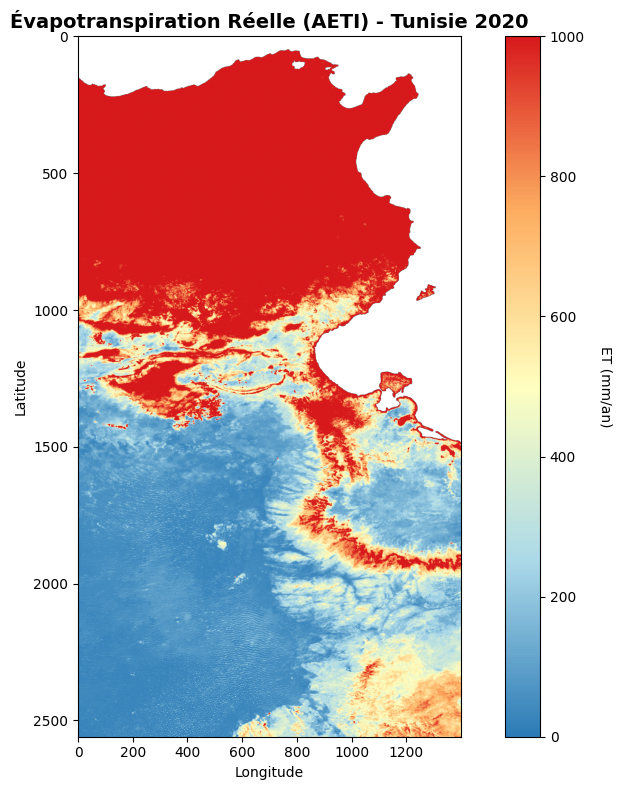


💡 Interprétation:
  🔵 Bleu: Zones irriguées, végétation dense
  🟡 Jaune: Cultures pluviales
  🔴 Rouge: Zones arides, désert


In [64]:
#%pip install matplotlib
import rasterio
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

# Charger un fichier AETI (exemple: 2020)
et_file = "../data/raw/ET/AETI_L1_2020.tif"

with rasterio.open(et_file) as src:
    et_data = src.read(1)
    
    # Remplacer les valeurs NoData par NaN
    et_data = et_data.astype(float)
    et_data[et_data < 0] = np.nan
    
    # Afficher les statistiques
    print(f"📊 Statistiques AETI 2020 (mm/an):")
    print(f"  Min:     {np.nanmin(et_data):.1f} mm")
    print(f"  Max:     {np.nanmax(et_data):.1f} mm")
    print(f"  Moyenne: {np.nanmean(et_data):.1f} mm")
    print(f"  Médiane: {np.nanmedian(et_data):.1f} mm")
    
    # Créer la carte
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Colormap (bleu -> jaune -> rouge)
    colors = ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']
    cmap = LinearSegmentedColormap.from_list('et', colors[::-1])
    
    im = ax.imshow(et_data, cmap=cmap, vmin=0, vmax=1000)
    
    ax.set_title('Évapotranspiration Réelle (AETI) - Tunisie 2020', fontsize=14, fontweight='bold')
    ax.set_xlabel('Longitude')
    ax.set_ylabel('Latitude')
    
    cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    cbar.set_label('ET (mm/an)', rotation=270, labelpad=20)
    
    plt.tight_layout()
    plt.show()
    
    print("\n💡 Interprétation:")
    print("  🔵 Bleu: Zones irriguées, végétation dense")
    print("  🟡 Jaune: Cultures pluviales")
    print("  🔴 Rouge: Zones arides, désert")

📈 Évolution de l'ET en Tunisie:

 Année  ET_moyenne  ET_min  ET_max
  2018 1331.164411     0.0 16155.0
  2019 1422.668660     0.0 17856.0
  2020 1391.065100    20.0 17487.0
  2021 1233.641609     0.0 17051.0
  2022 1263.545001     0.0 16449.0
  2023 1040.389898     0.0 17034.0


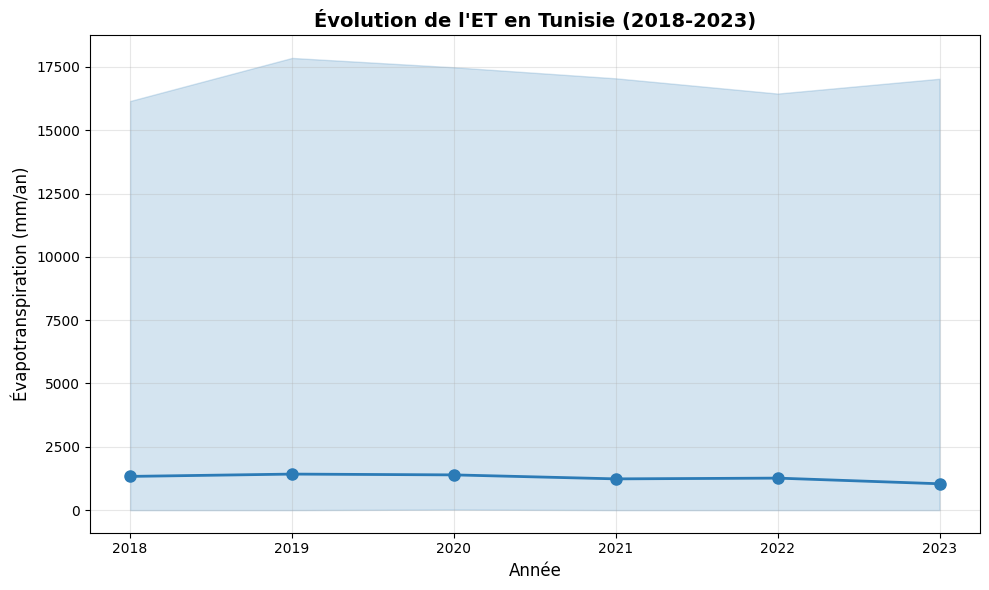

In [ ]:
# Évolution temporelle de l'ET moyenne
import pandas as pd

et_stats = []

for year in range(2018, 2024):
    et_file = f"../data/raw/ET/AETI_L1_{year}.tif"
    
    if os.path.exists(et_file):
        with rasterio.open(et_file) as src:
            et_data = src.read(1).astype(float)
            et_data[et_data < 0] = np.nan
            
            et_stats.append({
                'Année': year,
                'ET_moyenne': np.nanmean(et_data),
                'ET_min': np.nanmin(et_data),
                'ET_max': np.nanmax(et_data)
            })

df_et = pd.DataFrame(et_stats)
print("📈 Évolution de l'ET en Tunisie:\n")
print(df_et.to_string(index=False))

# Graphique
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_et['Année'], df_et['ET_moyenne'], marker='o', linewidth=2, markersize=8, color='#2c7bb6')
ax.fill_between(df_et['Année'], df_et['ET_min'], df_et['ET_max'], alpha=0.2, color='#2c7bb6')

ax.set_xlabel('Année', fontsize=12)
ax.set_ylabel('Évapotranspiration (mm/an)', fontsize=12)
ax.set_title('Évolution de l\'ET en Tunisie (2018-2023)', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Télécharger la transpiration annuelle

TBP (Transpiration) - nécessaire pour calculer l'évapotranspiration des biomasses

In [65]:
# Télécharger la transpiration annuelle
years = list(range(2015, 2024))  # 2015 to 2023
tbp_files = downloader.download_transpiration(years=years, level=2)

print(f"\n✓ {len(tbp_files)} fichiers TBP téléchargés")


📥 Téléchargement: Transpiration annuelle (Level 2)
  ✗ 2015: données non disponibles
  ✗ 2016: données non disponibles
  ✗ 2017: données non disponibles
  📥 2018: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✗ 2015: données non disponibles
  ✗ 2016: données non disponibles
  ✗ 2017: données non disponibles
  📥 2018: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/TBP/TBP_L2_2018.tif
  📥 2019: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/TBP/TBP_L2_2018.tif
  📥 2019: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/TBP/TBP_L2_2019.tif
  📥 2020: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/TBP/TBP_L2_2019.tif
  📥 2020: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ 

## 📊 Visualiser les données de transpiration (TBP)

📊 Statistiques TBP 2020 (mm/an):
  Min:     0.0 mm
  Max:     21740.0 mm
  Max:     21740.0 mm
  Moyenne: 579.1 mm
  Moyenne: 579.1 mm
  Médiane: 0.0 mm
  Médiane: 0.0 mm


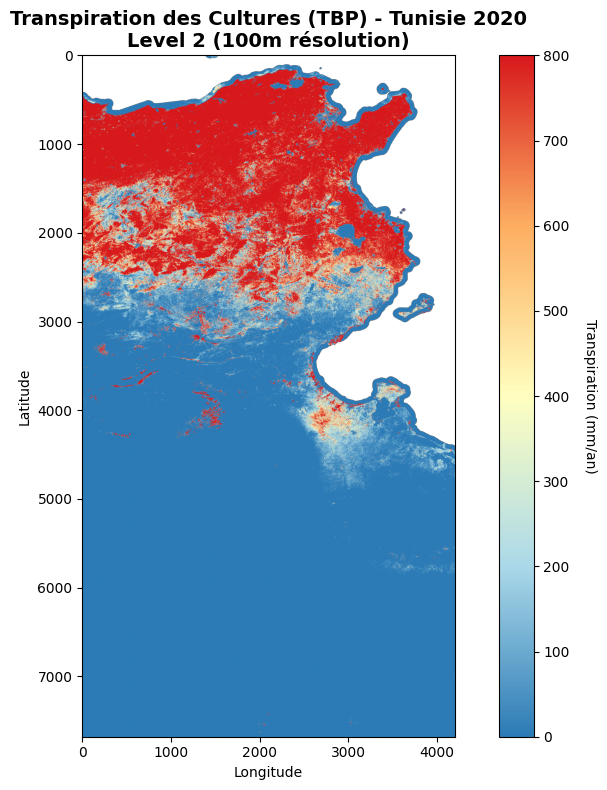


💡 TBP = Eau transpirée par les cultures uniquement
   (sans l'évaporation du sol)


In [68]:
# Visualiser la transpiration pour 2020
tbp_file = "../data/raw/TBP/TBP_L2_2020.tif"

if os.path.exists(tbp_file):
    with rasterio.open(tbp_file) as src:
        tbp_data = src.read(1).astype(float)
        tbp_data[tbp_data < 0] = np.nan
        
        # Statistiques
        print(f"📊 Statistiques TBP 2020 (mm/an):")
        print(f"  Min:     {np.nanmin(tbp_data):.1f} mm")
        print(f"  Max:     {np.nanmax(tbp_data):.1f} mm")
        print(f"  Moyenne: {np.nanmean(tbp_data):.1f} mm")
        print(f"  Médiane: {np.nanmedian(tbp_data):.1f} mm")
        
        # Carte
        fig, ax = plt.subplots(figsize=(12, 8))
        
        colors = ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']
        cmap = LinearSegmentedColormap.from_list('tbp', colors[::-1])
        
        im = ax.imshow(tbp_data, cmap=cmap, vmin=0, vmax=800)
        
        ax.set_title('Transpiration des Cultures (TBP) - Tunisie 2020\nLevel 2 (100m résolution)', 
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Transpiration (mm/an)', rotation=270, labelpad=20)
        
        plt.tight_layout()
        plt.show()
        
        print("\n💡 TBP = Eau transpirée par les cultures uniquement")
        print("   (sans l'évaporation du sol)")
else:
    print(f"⚠️ Fichier non trouvé: {tbp_file}")

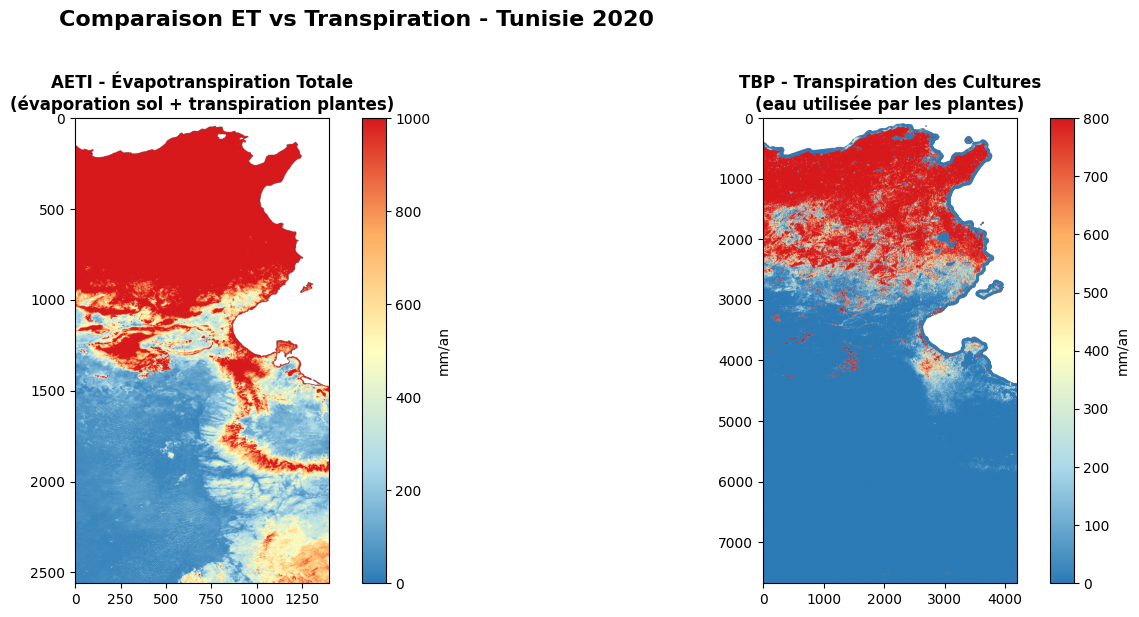


📊 Comparaison:
  ET moyenne:  1391.1 mm/an
  TBP moyenne: 579.1 mm/an
  TBP moyenne: 579.1 mm/an
  Différence:  812.0 mm/an (évaporation du sol)
  Différence:  812.0 mm/an (évaporation du sol)
  Ratio T/ET:  41.6%
  Ratio T/ET:  41.6%


In [ ]:
# Comparer ET vs Transpiration pour 2020
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# ET (AETI)
with rasterio.open("../data/raw/ET/AETI_L1_2020.tif") as src:
    et_data = src.read(1).astype(float)
    et_data[et_data < 0] = np.nan
    
    colors = ['#d7191c', '#fdae61', '#ffffbf', '#abd9e9', '#2c7bb6']
    cmap = LinearSegmentedColormap.from_list('et', colors[::-1])
    
    im1 = axes[0].imshow(et_data, cmap=cmap, vmin=0, vmax=1000)
    axes[0].set_title('AETI - Évapotranspiration Totale\n(évaporation sol + transpiration plantes)', 
                      fontsize=12, fontweight='bold')
    plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04, label='mm/an')

# TBP (Transpiration)
if os.path.exists("../data/raw/TBP/TBP_L2_2020.tif"):
    with rasterio.open("../data/raw/TBP/TBP_L2_2020.tif") as src:
        tbp_data = src.read(1).astype(float)
        tbp_data[tbp_data < 0] = np.nan
        
        im2 = axes[1].imshow(tbp_data, cmap=cmap, vmin=0, vmax=800)
        axes[1].set_title('TBP - Transpiration des Cultures\n(eau utilisée par les plantes)', 
                          fontsize=12, fontweight='bold')
        plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04, label='mm/an')

plt.suptitle('Comparaison ET vs Transpiration - Tunisie 2020', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

print(f"\n📊 Comparaison:")
print(f"  ET moyenne:  {np.nanmean(et_data):.1f} mm/an")
if os.path.exists("../data/raw/TBP/TBP_L2_2020.tif"):
    print(f"  TBP moyenne: {np.nanmean(tbp_data):.1f} mm/an")
    print(f"  Différence:  {np.nanmean(et_data) - np.nanmean(tbp_data):.1f} mm/an (évaporation du sol)")
    print(f"  Ratio T/ET:  {(np.nanmean(tbp_data) / np.nanmean(et_data) * 100):.1f}%")

## Télécharger les précipitations (PCP)

Les précipitations permettent d'identifier les zones irriguées (où AETI > PCP)

In [69]:
# Recharger le module pour avoir les nouvelles méthodes
importlib.reload(wapor_downloader)
from src.data.wapor_downloader import WaPORDownloader

# Réinitialiser le downloader
downloader = WaPORDownloader(config_path=config_path)

# Télécharger les précipitations
years = list(range(2018, 2024))
pcp_files = downloader.download_precipitation(years=years, level=1)

print(f"\n✓ {len(pcp_files)} fichiers PCP téléchargés")

ℹ️  GDAL non disponible - utilisation de rasterio pour le découpage
✓ WaPOR v3 Downloader initialisé
  API: https://data.apps.fao.org/gismgr/api/v2/catalog/workspaces/WAPOR-3/mapsets
  Période: 2015-2023
  Zone: Tunisia (bbox: [7.5, 30.0, 11.6, 37.5])

📥 Téléchargement: Précipitations annuelles (Level 1)
  📥 2018: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  📥 2018: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/PCP/PCP_L1_2018.tif
  📥 2019: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/PCP/PCP_L1_2018.tif
  📥 2019: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/PCP/PCP_L1_2019.tif
  📥 2020: téléchargement en cours...
  📥 Téléchargement et découpage avec rasterio...
  ✓ Téléchargé et découpé: data/raw/PCP/PCP_L1_2019.tif
  📥 2020: téléchargement en cours...
  📥

## 📊 Visualiser les précipitations

📊 Statistiques PCP 2020 (mm/an):
  Min:     118.0 mm
  Max:     17265.0 mm
  Moyenne: 1901.4 mm
  Médiane: 858.0 mm


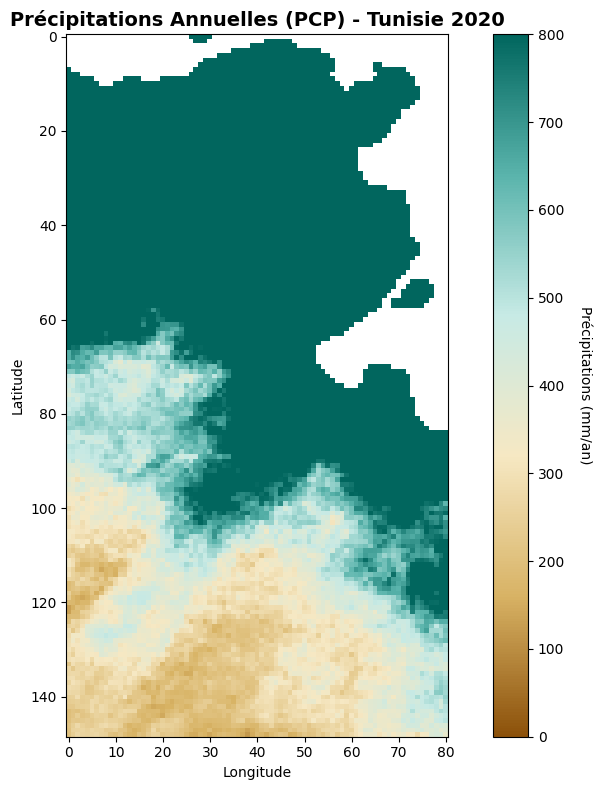


💡 Identification des zones irriguées:
   Irrigation probable si: AETI > PCP + marge


In [70]:
# Visualiser les précipitations pour 2020
pcp_file = "../data/raw/PCP/PCP_L1_2020.tif"

if os.path.exists(pcp_file):
    with rasterio.open(pcp_file) as src:
        pcp_data = src.read(1).astype(float)
        pcp_data[pcp_data < 0] = np.nan
        
        print(f"📊 Statistiques PCP 2020 (mm/an):")
        print(f"  Min:     {np.nanmin(pcp_data):.1f} mm")
        print(f"  Max:     {np.nanmax(pcp_data):.1f} mm")
        print(f"  Moyenne: {np.nanmean(pcp_data):.1f} mm")
        print(f"  Médiane: {np.nanmedian(pcp_data):.1f} mm")
        
        fig, ax = plt.subplots(figsize=(12, 8))
        
        # Colormap pour précipitations (blanc -> bleu)
        colors = ['#8c510a', '#d8b365', '#f6e8c3', '#c7eae5', '#5ab4ac', '#01665e']
        cmap = LinearSegmentedColormap.from_list('pcp', colors)
        
        im = ax.imshow(pcp_data, cmap=cmap, vmin=0, vmax=800)
        
        ax.set_title('Précipitations Annuelles (PCP) - Tunisie 2020', 
                     fontsize=14, fontweight='bold')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Précipitations (mm/an)', rotation=270, labelpad=20)
        
        plt.tight_layout()
        plt.show()
        
        print("\n💡 Identification des zones irriguées:")
        print("   Irrigation probable si: AETI > PCP + marge")
else:
    print(f"⚠️ Fichier non trouvé: {pcp_file}")

## Télécharger la couverture du sol (LCC)

**⚠️ Problème**: WaPOR v2 et v3 n'ont pas de données LCC accessibles

**✓ Solution**: Utiliser **ESA WorldCover** (10m résolution, gratuit)
- Années disponibles: 2020, 2021
- 11 classes de couverture du sol
- Haute qualité, validation globale

In [102]:
# IMPORTANT: Recharger le module ESA mis à jour (version optimisée mémoire)
import importlib
from src.data import esa_worldcover_downloader
importlib.reload(esa_worldcover_downloader)
from src.data.esa_worldcover_downloader import ESAWorldCoverDownloader

# Réinitialiser le downloader avec le code optimisé (utiliser chemin absolu)
config_path_abs = os.path.abspath(config_path)
esa_downloader = ESAWorldCoverDownloader(config_path=config_path_abs)
print("✓ Module ESA WorldCover rechargé (version optimisée)")

✓ ESA WorldCover Downloader initialisé
  Source: ESA WorldCover (10m résolution)
  Années disponibles: 2020, 2021
  Zone: Tunisia (bbox: [7.5, 30.0, 11.6, 37.5])
✓ Module ESA WorldCover rechargé (version optimisée)


In [103]:
import os
if os.path.exists("../data/raw/LCC/LCC_ESA_2020.tif"):
    os.remove("../data/raw/LCC/LCC_ESA_2020.tif")
    print("✓ Ancien fichier supprimé")

✓ Ancien fichier supprimé


In [104]:
# Télécharger ESA WorldCover 2020 (haute résolution 10m)
# Note: Ce téléchargement peut prendre plusieurs minutes (fichiers volumineux)

lcc_file_2020 = esa_downloader.download_and_crop_land_cover(year=2020)

if lcc_file_2020:
    print(f"\n✓ LCC 2020 téléchargé avec succès!")
    print(f"  Fichier: {lcc_file_2020}")
else:
    print("\n✗ Échec du téléchargement LCC")


📥 Téléchargement: ESA WorldCover 2020
ℹ️  Résolution: 10m (haute résolution)
ℹ️  Classes: 11 types de couverture du sol

📦 Téléchargement de 6 tuiles...

🔗 Découpage des tuiles à la bbox Tunisie...
  📐 Découpage tuile 1/6... ✓ (1.3MB)
  📐 Découpage tuile 2/6... ✓ (1.3MB)
  📐 Découpage tuile 2/6... ✓ (3.6MB)
  📐 Découpage tuile 3/6... ✓ (3.6MB)
  📐 Découpage tuile 3/6... ✓ (20.0MB)
  📐 Découpage tuile 4/6... ✓ (20.0MB)
  📐 Découpage tuile 4/6... ✓ (40.2MB)
  📐 Découpage tuile 5/6... ✓ (40.2MB)
  📐 Découpage tuile 5/6... ✓ (12.2MB)
  📐 Découpage tuile 6/6... ✓ (12.2MB)
  📐 Découpage tuile 6/6... ✓ (18.4MB)

🔗 Fusion de 6 tuiles...
✓ (18.4MB)

🔗 Fusion de 6 tuiles...
  📏 Mosaïque: 31199x36000 pixels
  📏 Mosaïque: 31199x36000 pixels
  ✍️ Tuile 1/6...   ✍️ Tuile 1/6... ✓
  ✍️ Tuile 2/6... ✓
  ✍️ Tuile 2/6... ✓
  ✍️ Tuile 3/6... ✓
  ✍️ Tuile 3/6... ✓
  ✍️ Tuile 4/6... ✓
  ✍️ Tuile 4/6... ✓
  ✍️ Tuile 5/6... ✓
  ✍️ Tuile 5/6... ✓
  ✍️ Tuile 6/6... ✓
  ✍️ Tuile 6/6... ✓
✓
✓ Fichier créé: c:\S

## 📊 Visualiser la couverture du sol (LCC)

📊 ESA WorldCover 2020 - Tunisie
  Dimensions: 31199 x 36000 pixels
  Résolution: 0.0m x 0.0m
  Taille fichier: 76.8 MB

🔄 Chargement image décimée (1/20 résolution)...
  Classes présentes: [10, 20, 30, 40, 50, 60, 80, 90]

📈 Distribution des classes:
   10 - Arbre               :   3.5%
   20 - Arbustes            :   2.0%
   30 - Herbacées           :  11.6%
   40 - Terres cultivées    :  16.6%
   50 - Bâti                :   1.5%
   60 - Végétation clairsemée:  30.5%
   80 - Eau                 :  33.9%
   90 - Zones humides       :   0.4%
  Classes présentes: [10, 20, 30, 40, 50, 60, 80, 90]

📈 Distribution des classes:
   10 - Arbre               :   3.5%
   20 - Arbustes            :   2.0%
   30 - Herbacées           :  11.6%
   40 - Terres cultivées    :  16.6%
   50 - Bâti                :   1.5%
   60 - Végétation clairsemée:  30.5%
   80 - Eau                 :  33.9%
   90 - Zones humides       :   0.4%


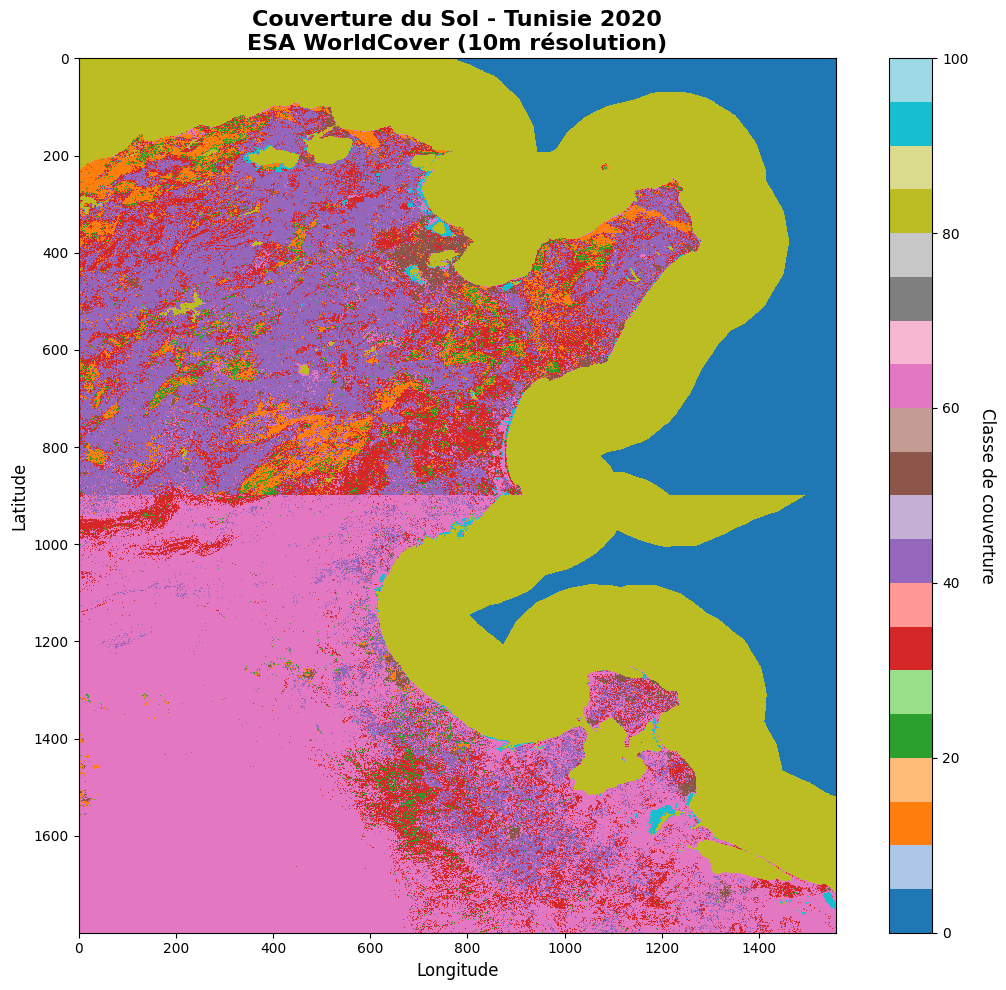


💡 Interprétation pour l'agriculture:
   40 = Terres cultivées (irrigué + pluvial)
   30 = Herbacées (pâturages, cultures extensives)
   60 = Végétation clairsemée (zones arides)


In [105]:
# Visualiser la couverture du sol ESA WorldCover 2020
lcc_file = "../data/raw/LCC/LCC_ESA_2020.tif"

if os.path.exists(lcc_file):
    with rasterio.open(lcc_file) as src:
        print(f"📊 ESA WorldCover 2020 - Tunisie")
        print(f"  Dimensions: {src.width} x {src.height} pixels")
        print(f"  Résolution: {abs(src.res[0]):.1f}m x {abs(src.res[1]):.1f}m")
        print(f"  Taille fichier: {os.path.getsize(lcc_file) / (1024**2):.1f} MB")
        
        # Lire une version décimée (1 pixel sur 20) pour visualisation et statistiques
        print("\n🔄 Chargement image décimée (1/20 résolution)...")
        out_shape = (src.height // 20, src.width // 20)
        lcc_data = src.read(1, out_shape=out_shape)
        
        # Calculer statistiques sur l'image décimée
        unique_classes, counts = np.unique(lcc_data[lcc_data > 0], return_counts=True)
        total_pixels = counts.sum()
        
        print(f"  Classes présentes: {[int(c) for c in unique_classes]}")
        
        # Légende ESA WorldCover
        legend = {
            10: "Arbre", 20: "Arbustes", 30: "Herbacées",
            40: "Terres cultivées", 50: "Bâti", 60: "Végétation clairsemée",
            70: "Neige/glace", 80: "Eau", 90: "Zones humides",
            95: "Mangroves", 100: "Mousses/lichens"
        }
        
        # Distribution des classes
        print("\n📈 Distribution des classes:")
        for cls, count in zip(unique_classes, counts):
            percent = (count / total_pixels) * 100
            label = legend.get(int(cls), f"Classe {int(cls)}")
            print(f"  {int(cls):3d} - {label:20s}: {percent:5.1f}%")
        
        fig, ax = plt.subplots(figsize=(14, 10))
        
        # Colormap pour ESA WorldCover
        from matplotlib.colors import ListedColormap
        colors_esa = {
            10: '#006400',  # Vert foncé - Arbres
            20: '#ffbb22',  # Jaune-orange - Arbustes
            30: '#ffff4c',  # Jaune - Herbacées
            40: '#f096ff',  # Rose - Cultures
            50: '#fa0000',  # Rouge - Bâti
            60: '#b4b4b4',  # Gris - Végétation clairsemée
            70: '#f0f0f0',  # Blanc - Neige
            80: '#0064c8',  # Bleu - Eau
            90: '#0096a0',  # Cyan - Zones humides
            95: '#00cf75',  # Vert clair - Mangroves
            100: '#fae6a0',  # Beige - Mousses
        }
        
        # Utiliser colormap discrète
        im = ax.imshow(lcc_data, cmap='tab20', interpolation='nearest', vmin=0, vmax=100)
        
        ax.set_title('Couverture du Sol - Tunisie 2020\nESA WorldCover (10m résolution)', 
                     fontsize=16, fontweight='bold')
        ax.set_xlabel('Longitude', fontsize=12)
        ax.set_ylabel('Latitude', fontsize=12)
        
        cbar = plt.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
        cbar.set_label('Classe de couverture', rotation=270, labelpad=20, fontsize=12)
        
        plt.tight_layout()
        plt.show()
        
        print("\n💡 Interprétation pour l'agriculture:")
        print("   40 = Terres cultivées (irrigué + pluvial)")
        print("   30 = Herbacées (pâturages, cultures extensives)")
        print("   60 = Végétation clairsemée (zones arides)")
        
else:
    print(f"⚠️ Fichier non trouvé: {lcc_file}")
    print("   Exécutez d'abord la cellule de téléchargement ESA WorldCover")